# Norm and Dir with CIFAR100
__efficientnetb3 -> b0__

In [19]:
from utils.loss_functions import DKDLoss
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from models_package.models import Teacher, Student
from torchvision import datasets, transforms, models
import models_package
import time
import json
import random
import logging
from pathlib import Path
import argparse
import warnings
from torch.utils.tensorboard import SummaryWriter
import pdb
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os
from pathlib import Path
from collections import OrderedDict
import shutil

# new libraries
from data.data_loader import load_cifar10, load_cifar100, load_imagenet, load_prof
import boto3
import io
import models_package
from utils.loss_functions import DKDLoss, DirectNormLoss, KDLoss
from utils.compare_tools import compare_model_size, compare_inference_time, compare_performance_metrics, plot_comparison
from utils.misc_tools import colorstr, Save_Checkpoint, AverageMeter, epoch_loop_reviewkd
from utils.misc_tools import best_LR, best_LR_nd, best_LR_wider, train_teacher, train_teacher_wider, train_teacher_efficientnet, retrieve_teacher_class_weights, new_teacher_class_weights


## Find best LR

In [5]:
# Hyperparameters
learning_rate = 0.003  # 0.01 for resnet34x2 & 0.1 for resnet8 & 0.003 for resnet 8x4
num_epochs = 240
num_workers = 2
batch_size = 64
temperature = 4.0
alpha = 0.9
momentum = 0.9
num_classes = 100
step_size = 30
gamma = 0.1

# new parameters
# lr_input = 0.1
# momentum_input = 0.9
weight_decay_input = 5e-4
# epochs = 20
# T = 4.0 # temperatureture
# alpha = 0.9
patience = 5  # for early stopping

In [6]:
torch.cuda.device_count()

1

## Load in Data

In [7]:
# Load IdenProf dataset
trainloader, testloader  = load_cifar100(batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


## Load in models

### efficientnet

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
##### HELPER FUNCTION FOR FEATURE EXTRACTION

def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

In [10]:
teacher_model = torchvision.models.efficientnet_b3(weights='DEFAULT')
teacher_model.our_classifier = nn.Linear(1536, num_classes)

# register the hook
# teacher_model.avgpool.register_forward_hook(get_features('feats'))
teacher_model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [11]:
student_model = torchvision.models.efficientnet_b0(weights='DEFAULT')
student_model.classifier = nn.Linear(1280, num_classes)

In [12]:
# # Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the student model
student_optimizer = optim.SGD(student_model.parameters(), lr=learning_rate, momentum=momentum)
student_scheduler = torch.optim.lr_scheduler.StepLR(student_optimizer, step_size=step_size, gamma=gamma)


criterion = nn.CrossEntropyLoss()
# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
# ##### FEATURE EXTRACTION LOOP

# # placeholders
# PREDS = []
# FEATS = []

# # placeholder for batch features
# features = {}

# # loop through batches
# for i, (inputs, labels) in enumerate(tqdm(trainloader)):

#     # move to device
#     inputs, labels = inputs.to(device), labels.to(device)
       
#     # forward pass [with feature extraction]
#     preds = teacher_model(inputs)
#     feats = features['feats']
#     emb_feats = torch.flatten(feats, 1)
    
#     # add feats  to lists
#     # FEATS.append(features['feats'].cpu().numpy())

#     # early stop
#     if i == 9:
#         break

  0%|                                                                                               | 0/4167 [00:01<?, ?it/s]


KeyError: 'feats'

## Best LR

In [11]:
def best_LR_here(save_name, model, trainloader, criterion, optimizer, scheduler, 
                num_epochs=5, emb = False, lr_range=(1e-4, 1e-1), plot_loss=True):
    def get_features(name):
        def hook(model, input, output):
            features[name] = output.detach()
        return hook
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.train()
    # create hook for feature embeddings
    model.to(device)
    model.avgpool.register_forward_hook(get_features('feats'))

    lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), num_epochs * len(trainloader))  # Generate learning rates for each batch
    lr_iter = iter(lr_values)
    losses = []
    lrs = []
    
    for epoch in range(num_epochs):
        features = {}
        for i, (inputs, labels) in enumerate(tqdm(trainloader)):
            lr = next(lr_iter)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr  # Set new learning rate
            
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            # the Norm and Direction models give 2 outputs - feature embeddings and output
            if emb:
                outputs = model(inputs)
                feats = features['feats'].cpu().numpy()
                emb_feats = feats.flatten()

                
                # _, outputs = model(inputs)
            else:
                outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            lrs.append(lr)
    
    # Calculate the derivative of the loss
    loss_derivative = np.gradient(losses)
    
    # Find the learning rate corresponding to the minimum derivative (steepest decline)
    best_lr_index = np.argmin(loss_derivative)
    best_lr = lrs[best_lr_index]

    
    plot_path = './figs/LR/'
    os.makedirs(plot_path, exist_ok=True)
    plot_name = str(plot_path + save_name)

    
    if plot_loss:
        plt.figure()
        plt.plot(lrs, losses)
        plt.xscale('log')
        plt.xlabel('Learning Rate')
        plt.ylabel('Loss')
        plt.title('Learning Rate Range Test')
        plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
        plt.legend()
        plt.savefig(plot_name, bbox_inches='tight')
        plt.show()
    
    print(f'Best learning rate: {best_lr}')
    return best_lr

100%|████████████████████████████████████████████████████████████████████████████████████| 4167/4167 [10:46<00:00,  6.45it/s]


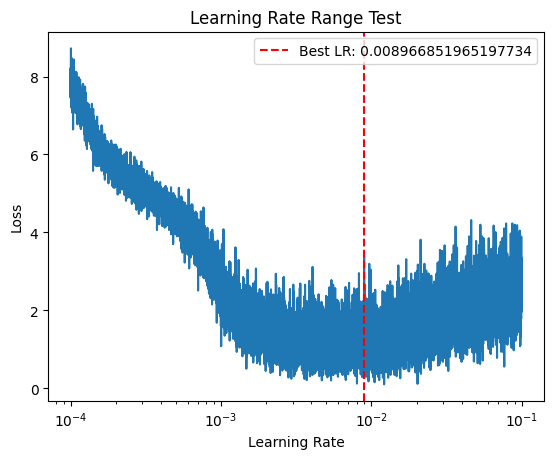

Best learning rate: 0.008966851965197734


0.008966851965197734

In [12]:
teacher_lr = best_LR_here('efficientnetb3_lr', teacher_model, trainloader, 
                     criterion, teacher_optimizer, 
                     teacher_scheduler, num_epochs=3, emb = True)
teacher_lr

100%|████████████████████████████████████████████████████████████████████████████████████| 4167/4167 [10:41<00:00,  6.50it/s]


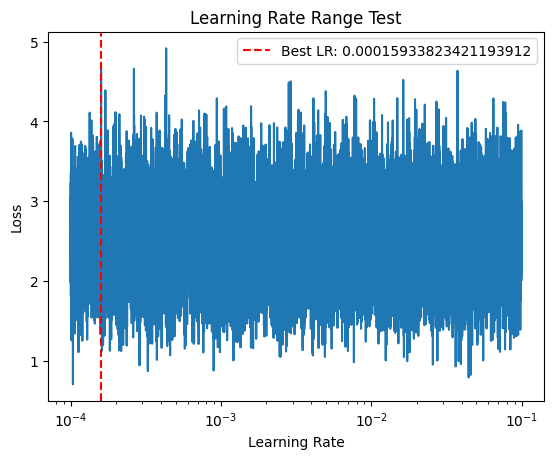

Best learning rate: 0.00015933823421193912


0.00015933823421193912

In [14]:
student_lr = best_LR_here('efficientnetb3_lr', student_model, trainloader, 
                     criterion, student_optimizer, 
                     student_scheduler, num_epochs=3, emb = False)
student_lr

In [13]:
teacher_lr = 0.008966851965197734
student_lr = 0.00015933823421193912

## Train Leaderboard Teacher Models

100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.54it/s]


*****Epoch 1/240*****
*****Train Loss:  3.572455 Val Loss:  1.099344*****
*****Validation Accuracy: 69.98%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.52it/s]


*****Epoch 2/240*****
*****Train Loss:  0.851416 Val Loss:  0.759364*****
*****Validation Accuracy: 77.63%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.54it/s]


*****Epoch 3/240*****
*****Train Loss:  0.504156 Val Loss:  0.598420*****
*****Validation Accuracy: 82.06%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.53it/s]


*****Epoch 4/240*****
*****Train Loss:  0.326142 Val Loss:  0.558159*****
*****Validation Accuracy: 83.70%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.53it/s]


*****Epoch 5/240*****
*****Train Loss:  0.209213 Val Loss:  0.605666*****
*****Validation Accuracy: 83.84%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.53it/s]


*****Epoch 6/240*****
*****Train Loss:  0.153938 Val Loss:  0.601262*****
*****Validation Accuracy: 84.69%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:45<00:00,  3.47it/s]


*****Epoch 7/240*****
*****Train Loss:  0.099784 Val Loss:  0.671684*****
*****Validation Accuracy: 84.05%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.54it/s]


*****Epoch 8/240*****
*****Train Loss:  0.069986 Val Loss:  0.770901*****
*****Validation Accuracy: 83.10%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.53it/s]


*****Epoch 9/240*****
*****Train Loss:  0.056506 Val Loss:  0.749191*****
*****Validation Accuracy: 83.99%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.54it/s]


*****Epoch 10/240*****
*****Train Loss:  0.073913 Val Loss:  0.734060*****
*****Validation Accuracy: 84.30%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.53it/s]


*****Epoch 11/240*****
*****Train Loss:  0.028557 Val Loss:  0.800365*****
*****Validation Accuracy: 83.84%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.54it/s]


*****Epoch 12/240*****
*****Train Loss:  0.029306 Val Loss:  0.800022*****
*****Validation Accuracy: 83.86%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.54it/s]


*****Epoch 13/240*****
*****Train Loss:  0.015626 Val Loss:  0.842686*****
*****Validation Accuracy: 84.51%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.54it/s]


*****Epoch 14/240*****
*****Train Loss:  0.019159 Val Loss:  0.794978*****
*****Validation Accuracy: 85.38%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.53it/s]


*****Epoch 15/240*****
*****Train Loss:  0.014428 Val Loss:  0.868567*****
*****Validation Accuracy: 84.55%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.54it/s]


*****Epoch 16/240*****
*****Train Loss:  0.012009 Val Loss:  0.826821*****
*****Validation Accuracy: 85.30%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.53it/s]


*****Epoch 17/240*****
*****Train Loss:  0.007535 Val Loss:  0.834455*****
*****Validation Accuracy: 85.75%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.53it/s]


*****Epoch 18/240*****
*****Train Loss:  0.005754 Val Loss:  0.835863*****
*****Validation Accuracy: 85.17%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.54it/s]


*****Epoch 19/240*****
*****Train Loss:  0.002840 Val Loss:  0.844916*****
*****Validation Accuracy: 86.03%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.53it/s]


*****Epoch 20/240*****
*****Train Loss:  0.001777 Val Loss:  0.866507*****
*****Validation Accuracy: 86.16%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.53it/s]


*****Epoch 21/240*****
*****Train Loss:  0.001608 Val Loss:  0.858702*****
*****Validation Accuracy: 86.41%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.53it/s]


*****Epoch 22/240*****
*****Train Loss:  0.001265 Val Loss:  0.857787*****
*****Validation Accuracy: 86.49%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.52it/s]


*****Epoch 23/240*****
*****Train Loss:  0.001078 Val Loss:  0.861669*****
*****Validation Accuracy: 86.47%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.52it/s]


*****Epoch 24/240*****
*****Train Loss:  0.000868 Val Loss:  0.869679*****
*****Validation Accuracy: 86.37%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.53it/s]


*****Epoch 25/240*****
*****Train Loss:  0.000803 Val Loss:  0.880199*****
*****Validation Accuracy: 86.42%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.53it/s]


*****Epoch 26/240*****
*****Train Loss:  0.000782 Val Loss:  0.886877*****
*****Validation Accuracy: 86.48%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.54it/s]


*****Epoch 27/240*****
*****Train Loss:  0.000797 Val Loss:  0.881332*****
*****Validation Accuracy: 86.44%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.53it/s]


*****Epoch 28/240*****
*****Train Loss:  0.000777 Val Loss:  0.885842*****
*****Validation Accuracy: 86.43%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.52it/s]


*****Epoch 29/240*****
*****Train Loss:  0.000593 Val Loss:  0.894483*****
*****Validation Accuracy: 86.44%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.53it/s]


*****Epoch 30/240*****
*****Train Loss:  0.000699 Val Loss:  0.897170*****
*****Validation Accuracy: 86.50%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.54it/s]


*****Epoch 31/240*****
*****Train Loss:  0.000421 Val Loss:  0.897063*****
*****Validation Accuracy: 86.47%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.54it/s]


*****Epoch 32/240*****
*****Train Loss:  0.000396 Val Loss:  0.897405*****
*****Validation Accuracy: 86.49%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.53it/s]


*****Epoch 33/240*****
*****Train Loss:  0.000378 Val Loss:  0.897972*****
*****Validation Accuracy: 86.45%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.53it/s]


*****Epoch 34/240*****
*****Train Loss:  0.000365 Val Loss:  0.898831*****
*****Validation Accuracy: 86.44%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.54it/s]


*****Epoch 35/240*****
*****Train Loss:  0.000356 Val Loss:  0.899851*****
*****Validation Accuracy: 86.44%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.53it/s]


*****Epoch 36/240*****
*****Train Loss:  0.000348 Val Loss:  0.901012*****
*****Validation Accuracy: 86.42%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.53it/s]


*****Epoch 37/240*****
*****Train Loss:  0.000343 Val Loss:  0.902112*****
*****Validation Accuracy: 86.46%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.53it/s]


*****Epoch 38/240*****
*****Train Loss:  0.000339 Val Loss:  0.903275*****
*****Validation Accuracy: 86.46%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.53it/s]


*****Epoch 39/240*****
*****Train Loss:  0.000337 Val Loss:  0.904535*****
*****Validation Accuracy: 86.45%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.53it/s]


*****Epoch 40/240*****
*****Train Loss:  0.000335 Val Loss:  0.905875*****
*****Validation Accuracy: 86.45%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.52it/s]


*****Epoch 41/240*****
*****Train Loss:  0.000333 Val Loss:  0.907078*****
*****Validation Accuracy: 86.47%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.53it/s]


*****Epoch 42/240*****
*****Train Loss:  0.000331 Val Loss:  0.908373*****
*****Validation Accuracy: 86.42%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.53it/s]


*****Epoch 43/240*****
*****Train Loss:  0.000331 Val Loss:  0.909512*****
*****Validation Accuracy: 86.49%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.53it/s]


*****Epoch 44/240*****
*****Train Loss:  0.000330 Val Loss:  0.911086*****
*****Validation Accuracy: 86.47%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.53it/s]


*****Epoch 45/240*****
*****Train Loss:  0.000328 Val Loss:  0.912118*****
*****Validation Accuracy: 86.48%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.52it/s]


*****Epoch 46/240*****
*****Train Loss:  0.000328 Val Loss:  0.913178*****
*****Validation Accuracy: 86.46%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.54it/s]


*****Epoch 47/240*****
*****Train Loss:  0.000328 Val Loss:  0.914491*****
*****Validation Accuracy: 86.48%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.53it/s]


*****Epoch 48/240*****
*****Train Loss:  0.000327 Val Loss:  0.915613*****
*****Validation Accuracy: 86.49%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.54it/s]


*****Epoch 49/240*****
*****Train Loss:  0.000326 Val Loss:  0.916802*****
*****Validation Accuracy: 86.48%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.52it/s]


*****Epoch 50/240*****
*****Train Loss:  0.000324 Val Loss:  0.917904*****
*****Validation Accuracy: 86.50%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.54it/s]


*****Epoch 51/240*****
*****Train Loss:  0.000324 Val Loss:  0.919045*****
*****Validation Accuracy: 86.51%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.53it/s]


*****Epoch 52/240*****
*****Train Loss:  0.000324 Val Loss:  0.920170*****
*****Validation Accuracy: 86.50%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.53it/s]


*****Epoch 53/240*****
*****Train Loss:  0.000324 Val Loss:  0.921316*****
*****Validation Accuracy: 86.51%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.54it/s]


*****Epoch 54/240*****
*****Train Loss:  0.000321 Val Loss:  0.922354*****
*****Validation Accuracy: 86.51%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.54it/s]


*****Epoch 55/240*****
*****Train Loss:  0.000322 Val Loss:  0.923442*****
*****Validation Accuracy: 86.51%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.53it/s]


*****Epoch 56/240*****
*****Train Loss:  0.000323 Val Loss:  0.924490*****
*****Validation Accuracy: 86.51%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.52it/s]


*****Epoch 57/240*****
*****Train Loss:  0.000322 Val Loss:  0.925522*****
*****Validation Accuracy: 86.51%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:46<00:00,  3.39it/s]


*****Epoch 58/240*****
*****Train Loss:  0.000320 Val Loss:  0.926597*****
*****Validation Accuracy: 86.52%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.54it/s]


*****Epoch 59/240*****
*****Train Loss:  0.000320 Val Loss:  0.927520*****
*****Validation Accuracy: 86.52%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.53it/s]


*****Epoch 60/240*****
*****Train Loss:  0.000321 Val Loss:  0.928537*****
*****Validation Accuracy: 86.53%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.52it/s]


*****Epoch 61/240*****
*****Train Loss:  0.000299 Val Loss:  0.928601*****
*****Validation Accuracy: 86.53%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.53it/s]


*****Epoch 62/240*****
*****Train Loss:  0.000299 Val Loss:  0.928662*****
*****Validation Accuracy: 86.53%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.54it/s]


*****Epoch 63/240*****
*****Train Loss:  0.000299 Val Loss:  0.928728*****
*****Validation Accuracy: 86.53%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.53it/s]


*****Epoch 64/240*****
*****Train Loss:  0.000299 Val Loss:  0.928788*****
*****Validation Accuracy: 86.53%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.53it/s]


*****Epoch 65/240*****
*****Train Loss:  0.000299 Val Loss:  0.928857*****
*****Validation Accuracy: 86.53%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.54it/s]


*****Epoch 66/240*****
*****Train Loss:  0.000299 Val Loss:  0.928921*****
*****Validation Accuracy: 86.53%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.53it/s]


*****Epoch 67/240*****
*****Train Loss:  0.000299 Val Loss:  0.928989*****
*****Validation Accuracy: 86.52%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.53it/s]


*****Epoch 68/240*****
*****Train Loss:  0.000299 Val Loss:  0.929049*****
*****Validation Accuracy: 86.52%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.53it/s]


*****Epoch 69/240*****
*****Train Loss:  0.000299 Val Loss:  0.929110*****
*****Validation Accuracy: 86.52%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.52it/s]


*****Epoch 70/240*****
*****Train Loss:  0.000299 Val Loss:  0.929177*****
*****Validation Accuracy: 86.52%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.52it/s]


*****Epoch 71/240*****
*****Train Loss:  0.000299 Val Loss:  0.929240*****
*****Validation Accuracy: 86.52%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.53it/s]


*****Epoch 72/240*****
*****Train Loss:  0.000299 Val Loss:  0.929304*****
*****Validation Accuracy: 86.52%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.52it/s]


*****Epoch 73/240*****
*****Train Loss:  0.000299 Val Loss:  0.929368*****
*****Validation Accuracy: 86.52%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.52it/s]


*****Epoch 74/240*****
*****Train Loss:  0.000299 Val Loss:  0.929430*****
*****Validation Accuracy: 86.52%*****

Early stopping
Finished Training Teacher


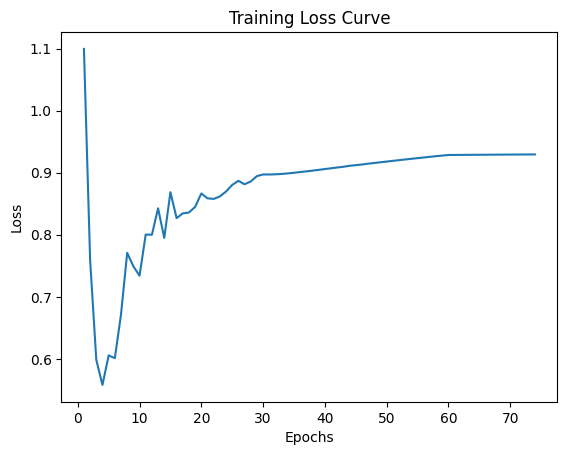

Training took 785.5598728060722 minutes


In [14]:
import time

start = time.time()

teacher_efficientnetb3 = train_teacher_efficientnet('efficientnetb3/CIFAR100', teacher_model, trainloader, testloader, criterion, teacher_optimizer, teacher_scheduler, num_epochs=240, patience=5)

end = time.time()

print(f'Training took {(end - start) / 60} minutes')



In [15]:
## load saved model
PATH = './weights/efficientnetb3/CIFAR100/weights.pth'
teacher_model.load_state_dict(torch.load(PATH))
teacher_model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [16]:
###################### Saving weights and movel using s3 bucket ######################

session = boto3.session.Session()
s3 = session.client('s3')

bucket_name = '210bucket' 

# Teacher Model
#### IMPORTANT!!!!! Change the file name so that you do not overwrite the existing files
teacher_model_weights_path = 'weights/teacher_CIFAR100_weights_efficientnetb3.pth'
teacher_model_path = 'models/testing_teacher_CIFAR100_efficientnetb3.pth'

# Save state dict to buffer
teacher_model_weights_buffer = io.BytesIO()
torch.save(teacher_model.state_dict(), teacher_model_weights_buffer)
teacher_model_weights_buffer.seek(0)

# Save entire model to buffer
teacher_model_buffer = io.BytesIO()
torch.save(teacher_model, teacher_model_buffer)
teacher_model_buffer.seek(0)

# Upload to S3
s3.put_object(Bucket=bucket_name, Key=teacher_model_weights_path, Body=teacher_model_weights_buffer)
s3.put_object(Bucket=bucket_name, Key=teacher_model_path, Body=teacher_model_buffer)
print('teacher weights and architecture saved and exported to S3')

teacher weights and architecture saved and exported to S3


## Extract Class Embeddings

In [24]:
def get_emb_fea(model, dataloader, batch_size):
    ''' Used to extract the feature embeddings in a teacher model '''
    
    def get_features(name):
        def hook(model, input, output):
            features[name] = output.detach()
        return hook

    
    model.eval()
    model.avgpool.register_forward_hook(get_features('feats'))

    EMB = {}


    with torch.no_grad():
        for images, labels in dataloader:
            FEATS = []
            features = {}
            curr_batch_size = len(images)
            images, labels = images.cuda(), labels.cuda()

            # compute output
            # emb_fea, logits = model(images, embed=True)
            outputs = model(images)
            # feats = features['feats'].cpu().numpy()
            # emb_fea = feats.flatten()
            FEATS.append(features['feats'].cpu().numpy())
            emb_fea = np.concatenate(FEATS)
            # reshape embedding features to flatten 
            emb_fea = emb_fea.reshape((curr_batch_size, emb_fea.shape[1]))


            for emb, i in zip(emb_fea, labels):
                i = i.item()
                emb_size = len(emb) 
                if str(i) in EMB:
                    for j in range(emb_size):
                        EMB[str(i)][j].append(round(emb[j].item(), 4))
                else:
                    EMB[str(i)] = [[] for _ in range(emb_size)]
                    for j in range(emb_size):
                        EMB[str(i)][j].append(round(emb[j].item(), 4))

    for key, value in EMB.items():
        for i in range(emb_size):
            EMB[key][i] = round(np.array(EMB[key][i]).mean(), 4)

    return EMB


def retrieve_teacher_class_weights(model_name, model, model_weight_path, num_class, data_name, dataloader, batch_size, bucket_name):
    ''' Use the extracted feature embeddings to create a json of class means for teacher'''

    session = boto3.session.Session()
    s3 = session.client('s3')

    teacher_model_weights_buffer = io.BytesIO()
    s3.download_fileobj(bucket_name, model_weight_path, teacher_model_weights_buffer)
    teacher_model_weights_buffer.seek(0)  

    # Load the model
    # model = models_package.__dict__[model_name](num_class=num_class)
    checkpoint = torch.load(teacher_model_weights_buffer)
    # print("Keys in checkpoint:", checkpoint.keys())
    print("model is loaded properly")

    new_state_dict = OrderedDict()
    for k, v in checkpoint.items():
        name = k[7:] if k.startswith('module.') else k
        new_state_dict[name] = v
    model.load_state_dict(new_state_dict)
    model.eval()

    for param in model.parameters():
        param.requires_grad = False
    
    model = model.cuda()

    # emb = get_emb_fea(model=model, dataloader=dataloader, batch_size=batch_size)
    # emb_json = json.dumps(emb, indent=4)
    # with open("./class_means/{}_embedding_fea/{}.json".format(data_name, model_name), 'w', encoding='utf-8') as f:
    #     f.write(emb_json)

    emb = get_emb_fea(model=model, dataloader=dataloader, batch_size=batch_size)
    emb_json = json.dumps(emb, indent=4)

    # Create the directory if it doesn't exist
    output_dir = "./class_means/{}_embedding_fea".format(data_name)
    os.makedirs(output_dir, exist_ok=True)

    with open("{}/{}.json".format(output_dir, model_name), 'w', encoding='utf-8') as f:
        f.write(emb_json)

In [25]:
data_name = 'CIFAR100'
retrieve_teacher_class_weights('efficientnetb3', teacher_model, teacher_model_weights_path, num_classes, data_name, trainloader, batch_size, bucket_name)


model is loaded properly


# Knowledge Distillation 

In [26]:
def plot_loss_curve(losses):
    epochs = range(1, len(losses) + 1)
    plt.plot(epochs, losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Val Loss Curve')
    plt.show()

In [33]:
def train_student_with_distillation(student, teacher, trainloader, testloader, criterion, optimizer, 
                                              device, t, epochs, patience, T_EMB, num_classes, model_name, data_name, output_dir):

    def get_features(name):
        def hook(model, input, output):
            features[name] = output.detach()
        return hook
        
    warm_up=20.0 #loss weight warm up epochs
    cls_loss_factor =1.0 # cls loss weight factor
    kd_loss_factor =1.0 #KD loss weight factor
    nd_loss_factor =1.0 # ND loss weight factor
    kd_loss = KDLoss(kl_loss_factor=kd_loss_factor, T=t).to(device)
    nd_loss = DirectNormLoss(num_class=num_classes, nd_loss_factor=nd_loss_factor).to(device)
    
    teacher.eval()
    teacher.to(device)

    # set up teacher class embeddings
    T_EMB = T_EMB
    
    best_val_accuracy = 0
    best_total_val_loss = float('inf')
    best_epoch_accuracy = 0.0
    patience_counter = 0 
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        student.train()
        student.to(device)

        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0 

        # for step, (images, labels) in enumerate(trainloader):
        for step, (images, labels) in enumerate(tqdm(trainloader)):
            # set up feature collection for student
            s_FEATS = []
            features = {}
            
            images, labels = images.cuda(), labels.cuda()
            curr_batch_size = len(images)
            
            optimizer.zero_grad()

            # set a hook for penultimate layer feature embedding
            student.avgpool.register_forward_hook(get_features('feats'))
            
            # compute output
            s_logits = student(images)
    
            s_FEATS.append(features['feats'].cpu().numpy())
            s_emb = np.concatenate(s_FEATS)
            # print(f'before reshaping s_emb: {s_emb.shape}')
            # reshape embedding features to flatten 
            s_emb = s_emb.reshape((curr_batch_size, s_emb.shape[1]))
            s_emb = torch.from_numpy(s_emb)
            s_emb = s_emb.to(device)
    
            # fix embedding output on student model
            s_emb_size = 1280
            t_emb_size = 1536
            
            emb_inflate = nn.Sequential(
                nn.BatchNorm1d(s_emb_size),
                nn.Dropout(0.5),
                nn.Linear(s_emb_size, t_emb_size)
                )
            # clean_model
            for m in student.modules():
                if isinstance(m, nn.BatchNorm1d):
                    m.weight.data.fill_(1)
                    m.bias.data.zero_()
                elif isinstance(m, nn.Linear):
                    m.bias.data.zero_()
        
            # inflate size of student embeddings to match teacher embedding size
            emb_inflate.to(device)
            s_emb = emb_inflate(s_emb)
        
            logit_inflate = nn.Sequential(
                nn.Linear(1536, num_classes),
                )
            logit_inflate.to(device)
            s_out = logit_inflate(s_emb)

            with torch.no_grad():
                # set up feature collection for teacher
                t_FEATS = []
                features = {}

                # set a hook for penultimate layer feature embedding
                teacher.avgpool.register_forward_hook(get_features('feats'))

                # compute outputs
                t_logits = teacher(images)
    
                t_FEATS.append(features['feats'].cpu().numpy())
                t_emb = np.concatenate(t_FEATS)
                # reshape embedding features to flatten 
                t_emb = t_emb.reshape((curr_batch_size, t_emb.shape[1]))
            
            t_emb = torch.from_numpy(t_emb)    
            t_emb = t_emb.to(device)
            t_out = teacher.our_classifier(t_emb)

            ## Set up loss function
            
            #cls loss
            cls_loss = criterion(s_logits, labels) * cls_loss_factor
            # KD loss
            div_loss = kd_loss(s_out = s_out, t_out = t_out) * min(1.0, epoch/warm_up)
            # ND loss
            norm_dir_loss = nd_loss(s_emb=s_emb, t_emb=t_emb, T_EMB=T_EMB, labels=labels)
    
            loss = cls_loss + div_loss + norm_dir_loss
                
            loss.backward()
            optimizer.step()
            
            # save loss metrics
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1

        epoch_loss /= num_batches

        ######### Test loop #############

        student.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        # Validation after each epoch
        with torch.no_grad():
            # for step, (images, labels) in enumerate(testloader):
            for step, (val_images, val_labels) in enumerate(tqdm(testloader)):
            # for val_images, val_labels in testloader:
                val_images, val_labels = val_images.cuda(), val_labels.cuda()
                curr_batch_size = len(val_images)

                
                # Forward pass for validation
                val_student_outputs = student(val_images)
             
                val_loss = criterion(val_student_outputs, val_labels)
                total_val_loss += val_loss.item()
    
                # Compute the validation accuracy
                _, predicted = torch.max(val_student_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1

    
            total_val_loss /= num_batches

            val_losses.append(total_val_loss)
            accuracy = total_correct / total_samples
            val_accuracies.append(accuracy)
            print(f'*****Epoch {epoch + 1}/{epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n')
        

        # Check for early stopping
        if abs(total_val_loss) < abs(best_total_val_loss):
            best_total_val_loss = total_val_loss
            patience_counter = 0
            
            os.makedirs(output_dir, exist_ok=True)

            state_dict_path = os.path.join(output_dir, f'student_weights_{model_name}_{data_name}.pth')
            torch.save(student.state_dict(), state_dict_path)
            
            # model_path = os.path.join(output_dir, f'student_model_{model_name}_{data_name}.pth')
            # torch.save(student, model_path)

        else:
            patience_counter += 1 

        if patience_counter >= patience:
            # perform early stopping and save model 
            print('Early stopping')
            break  


    plot_loss_curve(val_losses)


In [37]:
def __main__():

    # set some params
    epochs = 240
    batch_size = 64
    num_classes = 100
    lr = 0.00015933823421193912
    teacher_weights_path = 'weights/teacher_CIFAR100_weights_efficientnetb3.pth'
    data_name='CIFAR100'
    model_name='efficientnetb3'
    output_dir = f'./run/{data_name}/KD++'
    
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    momentum = 0.9 # SGD momentum
    t=4.0 #temperature
    # warm_up=20.0 #loss weight warm up epochs
    weight_decay = 5e-4 
    patience = 5
    # cls_loss_factor =1.0 # cls loss weight factor
    # kd_loss_factor =1.0 #KD loss weight factor
    # nd_loss_factor =1.0 # ND loss weight factor
    # kd_loss = KDLoss(kl_loss_factor=kd_loss_factor, T=t).to(device)
    # nd_loss = DirectNormLoss(num_class=num_classes, nd_loss_factor=nd_loss_factor).to(device)

    # Make dataloader
    trainloader, testloader  = load_cifar100(batch_size=batch_size)
    
    # load in models
    student = torchvision.models.efficientnet_b0(weights='DEFAULT')
    student.classifier = nn.Linear(1280, num_classes)
    # student.inflate_classifier = nn.Linear(1536, num_classes)
    
    teacher = torchvision.models.efficientnet_b3(weights='DEFAULT')
    teacher.our_classifier = nn.Linear(1536, num_classes)

    ### Load teacher weights from s3 bucket ### 
    print('Load Teacher Weights')
    
    session = boto3.session.Session()
    s3 = session.client('s3')
    bucket_name = '210bucket' 

    teacher_model_weights_buffer = io.BytesIO()
    s3.download_fileobj(bucket_name, teacher_weights_path, teacher_model_weights_buffer)
    teacher_model_weights_buffer.seek(0)  

    # Load the model
    # model = models_package.__dict__[model_name](num_class=num_class)
    teacher_ckpt = torch.load(teacher_model_weights_buffer)
    teacher.load_state_dict(teacher_ckpt)
    # print("Keys in checkpoint:", teacher_ckpt.keys())
    print("model is loaded properly")

        
    # teacher_ckpt = torch.load(teacher_weights)['model']
    # teacher.load_state_dict(teacher_ckpt)

    for param in teacher.parameters():
        param.requires_grad = False

    ## get teacher class mean embeddings
    with open("./class_means/CIFAR100_embedding_fea/efficientnetb3.json", 'r') as f:
        T_EMB = json.load(f)
    f.close()

    optimizer = torch.optim.SGD(params=student.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay, nesterov=True)
    criterion = nn.CrossEntropyLoss().to(device)


    # Train the model
    # epoch_loop(model=model, teacher=teacher, train_loader = trainloader, test_loader = testloader, num_class = num_classes, T_EMB = T_EMB, save_dir = save_dir, batch_size = batch_size, logger = logger)

    train_student_with_distillation(student, teacher, trainloader, testloader, criterion, optimizer, 
                                              device, t, epochs, patience, T_EMB, num_classes, model_name, data_name, output_dir)
    

In [38]:
__main__()

Files already downloaded and verified
Files already downloaded and verified
Load Teacher Weights
model is loaded properly


100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:28<00:00,  5.57it/s]


*****Epoch 1/240*****
*****Train Loss:  5.554766 Val Loss:  4.472074*****
*****Validation Accuracy: 5.64%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:28<00:00,  5.57it/s]


*****Epoch 2/240*****
*****Train Loss:  5.415397 Val Loss:  4.275696*****
*****Validation Accuracy: 18.82%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:28<00:00,  5.57it/s]


*****Epoch 3/240*****
*****Train Loss:  5.219006 Val Loss:  3.998267*****
*****Validation Accuracy: 31.22%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:28<00:00,  5.57it/s]


*****Epoch 4/240*****
*****Train Loss:  4.932229 Val Loss:  3.638976*****
*****Validation Accuracy: 41.30%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:28<00:00,  5.56it/s]


*****Epoch 5/240*****
*****Train Loss:  4.574952 Val Loss:  3.191575*****
*****Validation Accuracy: 46.64%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:28<00:00,  5.55it/s]


*****Epoch 6/240*****
*****Train Loss:  4.167224 Val Loss:  2.736722*****
*****Validation Accuracy: 51.60%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:28<00:00,  5.58it/s]


*****Epoch 7/240*****
*****Train Loss:  3.759634 Val Loss:  2.313844*****
*****Validation Accuracy: 56.29%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:28<00:00,  5.51it/s]


*****Epoch 8/240*****
*****Train Loss:  3.414539 Val Loss:  1.966047*****
*****Validation Accuracy: 59.90%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:28<00:00,  5.49it/s]


*****Epoch 9/240*****
*****Train Loss:  3.152962 Val Loss:  1.706347*****
*****Validation Accuracy: 62.74%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:28<00:00,  5.48it/s]


*****Epoch 10/240*****
*****Train Loss:  2.958007 Val Loss:  1.518335*****
*****Validation Accuracy: 65.02%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:28<00:00,  5.48it/s]


*****Epoch 11/240*****
*****Train Loss:  2.820723 Val Loss:  1.384882*****
*****Validation Accuracy: 66.83%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:28<00:00,  5.47it/s]


*****Epoch 12/240*****
*****Train Loss:  2.719114 Val Loss:  1.280791*****
*****Validation Accuracy: 67.83%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:29<00:00,  5.39it/s]


*****Epoch 13/240*****
*****Train Loss:  2.648434 Val Loss:  1.196773*****
*****Validation Accuracy: 69.36%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:28<00:00,  5.42it/s]


*****Epoch 14/240*****
*****Train Loss:  2.591274 Val Loss:  1.127653*****
*****Validation Accuracy: 70.63%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:29<00:00,  5.38it/s]


*****Epoch 15/240*****
*****Train Loss:  2.548306 Val Loss:  1.058845*****
*****Validation Accuracy: 71.75%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:29<00:00,  5.38it/s]


*****Epoch 16/240*****
*****Train Loss:  2.510290 Val Loss:  1.010285*****
*****Validation Accuracy: 72.67%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:29<00:00,  5.31it/s]


*****Epoch 17/240*****
*****Train Loss:  2.486311 Val Loss:  0.970510*****
*****Validation Accuracy: 73.19%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:29<00:00,  5.28it/s]


*****Epoch 18/240*****
*****Train Loss:  2.462295 Val Loss:  0.934772*****
*****Validation Accuracy: 73.98%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:29<00:00,  5.28it/s]


*****Epoch 19/240*****
*****Train Loss:  2.448456 Val Loss:  0.901096*****
*****Validation Accuracy: 74.79%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:29<00:00,  5.27it/s]


*****Epoch 20/240*****
*****Train Loss:  2.436323 Val Loss:  0.867644*****
*****Validation Accuracy: 75.38%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:29<00:00,  5.25it/s]


*****Epoch 21/240*****
*****Train Loss:  2.433321 Val Loss:  0.839913*****
*****Validation Accuracy: 75.80%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:30<00:00,  5.19it/s]


*****Epoch 22/240*****
*****Train Loss:  2.398628 Val Loss:  0.820112*****
*****Validation Accuracy: 76.59%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:30<00:00,  5.19it/s]


*****Epoch 23/240*****
*****Train Loss:  2.373431 Val Loss:  0.798678*****
*****Validation Accuracy: 76.78%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:30<00:00,  5.16it/s]


*****Epoch 24/240*****
*****Train Loss:  2.346373 Val Loss:  0.773470*****
*****Validation Accuracy: 77.50%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:30<00:00,  5.11it/s]


*****Epoch 25/240*****
*****Train Loss:  2.329254 Val Loss:  0.765586*****
*****Validation Accuracy: 77.69%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:30<00:00,  5.07it/s]


*****Epoch 26/240*****
*****Train Loss:  2.304077 Val Loss:  0.748978*****
*****Validation Accuracy: 77.77%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:31<00:00,  5.04it/s]


*****Epoch 27/240*****
*****Train Loss:  2.280232 Val Loss:  0.739217*****
*****Validation Accuracy: 78.22%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:31<00:00,  5.04it/s]


*****Epoch 28/240*****
*****Train Loss:  2.261197 Val Loss:  0.724402*****
*****Validation Accuracy: 78.57%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:31<00:00,  5.04it/s]


*****Epoch 29/240*****
*****Train Loss:  2.243625 Val Loss:  0.714062*****
*****Validation Accuracy: 78.84%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:31<00:00,  5.01it/s]


*****Epoch 30/240*****
*****Train Loss:  2.226009 Val Loss:  0.702630*****
*****Validation Accuracy: 78.92%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:31<00:00,  4.94it/s]


*****Epoch 31/240*****
*****Train Loss:  2.211764 Val Loss:  0.687278*****
*****Validation Accuracy: 79.50%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.88it/s]


*****Epoch 32/240*****
*****Train Loss:  2.192335 Val Loss:  0.676344*****
*****Validation Accuracy: 79.79%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.89it/s]


*****Epoch 33/240*****
*****Train Loss:  2.180660 Val Loss:  0.666016*****
*****Validation Accuracy: 79.91%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.89it/s]


*****Epoch 34/240*****
*****Train Loss:  2.166057 Val Loss:  0.661794*****
*****Validation Accuracy: 79.92%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:31<00:00,  4.91it/s]


*****Epoch 35/240*****
*****Train Loss:  2.149165 Val Loss:  0.651716*****
*****Validation Accuracy: 80.35%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.87it/s]


*****Epoch 36/240*****
*****Train Loss:  2.140995 Val Loss:  0.645316*****
*****Validation Accuracy: 80.30%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.79it/s]


*****Epoch 37/240*****
*****Train Loss:  2.123699 Val Loss:  0.639121*****
*****Validation Accuracy: 80.46%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.79it/s]


*****Epoch 38/240*****
*****Train Loss:  2.114596 Val Loss:  0.632976*****
*****Validation Accuracy: 80.74%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:33<00:00,  4.75it/s]


*****Epoch 39/240*****
*****Train Loss:  2.105541 Val Loss:  0.622394*****
*****Validation Accuracy: 80.95%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:33<00:00,  4.68it/s]


*****Epoch 40/240*****
*****Train Loss:  2.095253 Val Loss:  0.618654*****
*****Validation Accuracy: 81.16%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:33<00:00,  4.68it/s]


*****Epoch 41/240*****
*****Train Loss:  2.075715 Val Loss:  0.613353*****
*****Validation Accuracy: 81.16%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:34<00:00,  4.60it/s]


*****Epoch 42/240*****
*****Train Loss:  2.070298 Val Loss:  0.606184*****
*****Validation Accuracy: 81.16%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:33<00:00,  4.62it/s]


*****Epoch 43/240*****
*****Train Loss:  2.061975 Val Loss:  0.606074*****
*****Validation Accuracy: 81.29%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:34<00:00,  4.60it/s]


*****Epoch 44/240*****
*****Train Loss:  2.054022 Val Loss:  0.600742*****
*****Validation Accuracy: 81.35%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:34<00:00,  4.54it/s]


*****Epoch 45/240*****
*****Train Loss:  2.040871 Val Loss:  0.590900*****
*****Validation Accuracy: 81.67%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:34<00:00,  4.50it/s]


*****Epoch 46/240*****
*****Train Loss:  2.030530 Val Loss:  0.590633*****
*****Validation Accuracy: 81.73%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:35<00:00,  4.40it/s]


*****Epoch 47/240*****
*****Train Loss:  2.022602 Val Loss:  0.589068*****
*****Validation Accuracy: 81.71%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:35<00:00,  4.48it/s]


*****Epoch 48/240*****
*****Train Loss:  2.014474 Val Loss:  0.582887*****
*****Validation Accuracy: 81.78%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:35<00:00,  4.37it/s]


*****Epoch 49/240*****
*****Train Loss:  2.007406 Val Loss:  0.581235*****
*****Validation Accuracy: 81.91%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:35<00:00,  4.38it/s]


*****Epoch 50/240*****
*****Train Loss:  1.999053 Val Loss:  0.574335*****
*****Validation Accuracy: 82.16%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:36<00:00,  4.31it/s]


*****Epoch 51/240*****
*****Train Loss:  1.992447 Val Loss:  0.571492*****
*****Validation Accuracy: 82.21%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:36<00:00,  4.29it/s]


*****Epoch 52/240*****
*****Train Loss:  1.979794 Val Loss:  0.571210*****
*****Validation Accuracy: 82.36%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:37<00:00,  4.17it/s]


*****Epoch 53/240*****
*****Train Loss:  1.975064 Val Loss:  0.572683*****
*****Validation Accuracy: 82.20%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:37<00:00,  4.17it/s]


*****Epoch 54/240*****
*****Train Loss:  1.966077 Val Loss:  0.563610*****
*****Validation Accuracy: 82.35%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:37<00:00,  4.15it/s]


*****Epoch 55/240*****
*****Train Loss:  1.960302 Val Loss:  0.558331*****
*****Validation Accuracy: 82.30%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:37<00:00,  4.15it/s]


*****Epoch 56/240*****
*****Train Loss:  1.954396 Val Loss:  0.554398*****
*****Validation Accuracy: 82.64%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:38<00:00,  4.05it/s]


*****Epoch 57/240*****
*****Train Loss:  1.948043 Val Loss:  0.556303*****
*****Validation Accuracy: 82.62%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:38<00:00,  4.04it/s]


*****Epoch 58/240*****
*****Train Loss:  1.940398 Val Loss:  0.555789*****
*****Validation Accuracy: 82.51%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:39<00:00,  3.96it/s]


*****Epoch 59/240*****
*****Train Loss:  1.937195 Val Loss:  0.552930*****
*****Validation Accuracy: 82.65%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:40<00:00,  3.90it/s]


*****Epoch 60/240*****
*****Train Loss:  1.925714 Val Loss:  0.548593*****
*****Validation Accuracy: 82.81%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:40<00:00,  3.88it/s]


*****Epoch 61/240*****
*****Train Loss:  1.923075 Val Loss:  0.550923*****
*****Validation Accuracy: 82.70%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:40<00:00,  3.83it/s]


*****Epoch 62/240*****
*****Train Loss:  1.912394 Val Loss:  0.548213*****
*****Validation Accuracy: 82.70%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:41<00:00,  3.78it/s]


*****Epoch 63/240*****
*****Train Loss:  1.907073 Val Loss:  0.541378*****
*****Validation Accuracy: 83.04%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:41<00:00,  3.78it/s]


*****Epoch 64/240*****
*****Train Loss:  1.900265 Val Loss:  0.543984*****
*****Validation Accuracy: 82.83%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:41<00:00,  3.79it/s]


*****Epoch 65/240*****
*****Train Loss:  1.896286 Val Loss:  0.546802*****
*****Validation Accuracy: 82.76%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:42<00:00,  3.70it/s]


*****Epoch 66/240*****
*****Train Loss:  1.889356 Val Loss:  0.543145*****
*****Validation Accuracy: 82.95%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:42<00:00,  3.71it/s]


*****Epoch 67/240*****
*****Train Loss:  1.884872 Val Loss:  0.539553*****
*****Validation Accuracy: 83.08%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:43<00:00,  3.64it/s]


*****Epoch 68/240*****
*****Train Loss:  1.878924 Val Loss:  0.536259*****
*****Validation Accuracy: 83.19%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:43<00:00,  3.59it/s]


*****Epoch 69/240*****
*****Train Loss:  1.871830 Val Loss:  0.536213*****
*****Validation Accuracy: 83.38%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:44<00:00,  3.53it/s]


*****Epoch 70/240*****
*****Train Loss:  1.869071 Val Loss:  0.533341*****
*****Validation Accuracy: 83.23%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:45<00:00,  3.42it/s]


*****Epoch 71/240*****
*****Train Loss:  1.865476 Val Loss:  0.535028*****
*****Validation Accuracy: 83.20%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:47<00:00,  3.33it/s]


*****Epoch 72/240*****
*****Train Loss:  1.854290 Val Loss:  0.533652*****
*****Validation Accuracy: 83.33%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:46<00:00,  3.36it/s]


*****Epoch 73/240*****
*****Train Loss:  1.854887 Val Loss:  0.534767*****
*****Validation Accuracy: 83.22%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:45<00:00,  3.45it/s]


*****Epoch 74/240*****
*****Train Loss:  1.851188 Val Loss:  0.535327*****
*****Validation Accuracy: 83.42%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:45<00:00,  3.44it/s]


*****Epoch 75/240*****
*****Train Loss:  1.845248 Val Loss:  0.529667*****
*****Validation Accuracy: 83.56%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:46<00:00,  3.38it/s]


*****Epoch 76/240*****
*****Train Loss:  1.840695 Val Loss:  0.529607*****
*****Validation Accuracy: 83.49%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:47<00:00,  3.31it/s]


*****Epoch 77/240*****
*****Train Loss:  1.836812 Val Loss:  0.527810*****
*****Validation Accuracy: 83.46%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:47<00:00,  3.33it/s]


*****Epoch 78/240*****
*****Train Loss:  1.832846 Val Loss:  0.530638*****
*****Validation Accuracy: 83.37%*****



 28%|████████████████████████▍                                                              | 44/157 [00:13<00:35,  3.17it/s]


KeyboardInterrupt: 